In [1]:
%matplotlib inline

# Pseudonana project: supporting the no-sex hypothesis via crossover detection.
The diploid diatom Thalassiosira pseudonana has never been observed to reproduce sexually in culture. Tony has shown that a group of 5 globally dispersed T. pseudonana isolates (CCMP 1335, 1007, 1012, 1014, 1015) exhibit extreme divergence from Hardy-Weinberg equilibrium, while two others (1013, 3367) do not, likely meaning that the former lack the ability to sexually reproduce not only in culture but also in wild, while the latter retain sex.

In [2]:
#importing necessary modules
import vcfparser
import sys
from operator import itemgetter
import matplotlib.pyplot as plt
import ast
from joblib import Parallel, delayed
import random
import numpy as np
from sklearn.metrics import jaccard_similarity_score

vcfroot = "../../vcf/GATK/"
vcfFileNames = ["1335full_phased.vcf", "1007_phased.vcf", "1012_phased.vcf", "1013_phased.vcf", "1014_phased.vcf", "1015_phased.vcf", "IT_phased.vcf"]
strainIDs = ["1335", "1007", "1012", "1013", "1014", "1015", "3367"]

# Basic functions for CO analysis
Basic functions for comparing two strains.

Physical phasing partially recovers haplotype information via sequence reads. A single read covering two heterozygous sites reveals which variants are co-resident on each chromosome. All 7 strains were sequenced with mate-paired reads, which allowed us to phase some pairs of SNPs that are more than 3000 bp apart. We used the ReadBackedPhasing module of the GATK tool set. https://www.broadinstitute.org/gatk/gatkdocs/org_broadinstitute_gatk_tools_walkers_phasing_ReadBackedPhasing.php

Here is one of the few websites that explains what HP tag of vcf file means.https://gatkforums.broadinstitute.org/discussion/5045/step-order-for-phasebytransmission-and-readbackedphasing

Using the phasing information, we estimated the density of crossover per kilobase between two strains. If a pair of SNPs are phased together in both strains, we can determine if there was a crossover between the heterozygous SNP pair by examining their orientation. 

Here are some minor yet important details to note. 
- We only examined the largest set of non-overlapping pairs in order to ensure that there is less chance of doubel crossover event happening between a pair of SNPs.
- We excluded pairs that seem to have a point mutation.
- We only examined pairs that have [avgDepth+-(factor)*stddiv], where factor is defaulted to infinity. However, this avgDepth value is naively calcuated by the average coverage of SNP positions not entire genome. It should be pretty close but I need to revisit this tagain.

The crossover density was simply determined by dividing the number of detected crossover events by the total length of genome examined.

In [3]:
#This function will create lists of pairs of SNP positions, 
#which a common between vcf1 and vcf2. They will be put into 
#a dictionary keyed with chromosome names.

def extractCommonPairs(vcf1, vcf2, save=True, filename="result.Pairs"):
    pairs = {}

    #comparing from vcf1 to vcf2
    for i in range(len(vcf1.variants)):
        rate = 10
        #printing the progress
        if(i%(len(vcf1.variants)/rate)==0): print str(i*1.0/(len(vcf1.variants))*100)+"% complete"

        #get a snp from vcf1
        snp = vcf1.variants[i]

        #getting haplotype blocks that has the snp
        block1 = vcf1.getHapBlockByPos(snp.chrom,snp.pos)
        block2 = vcf2.getHapBlockByPos(snp.chrom,snp.pos)
        
        #when a block that contain that SNP exists in both strains.
        if block1 != None and block2 != None:
            #get the current pos
            pivot_pos = snp.pos

            #compare against block1
            for comp in block1:
                if pivot_pos < comp.pos:

                    #check if comp.pos exist in block2:
                    for comp2 in block2:
                        if comp2.pos == comp.pos:
                            temp = pairs.get(snp.chrom, [])
                            temp.append((pivot_pos, comp.pos))
                            pairs[snp.chrom] = temp
                            
    if save:
        f = open(filename, "w")
        f.write(str(pairs))
        f.close()            
    
    return pairs

In [4]:
#This function greedily solves ISMP problem on the list 
#of pairs identified using above function, and saves the
#result in a file.

def maximum_interval_scheduling_problem(pairs, save=True, filename="result.MISPPairs"):
    ret = {}
    for key in pairs.keys():
        dic = pairs[key]
        
        #print key
        #print "Size before misp:", len(dic)
        
        sorted(dic, key=itemgetter(1))
        solution = []
        while dic != []:
            # Select the interval, x, with the earliest finishing time.
            _min = dic[0]
            solution.append(_min)
            temp = [x for x in dic if not(x[0]<_min[1])]
            dic = temp
        #print "Size before misp:", len(solution)
        ret[key] = solution
        
    if save:
        f = open(filename, "w")
        f.write(str(ret))
        f.close()
        
    return ret

In [5]:
#This function compairs two strains vcf1 and vcf2.
#It goes over every single common SNP pairs and see
#if there was a sign of crossover.
#The detail of the "sign" of crossover is expained in the
#isCrossover function. 

def compare(pairs, vcf1, vcf2, factor=None, verbose=True):
    #initializing variables.
    total_co_count = 0
    total_genome_size = 0
    total_pairs_examined = 0
    
    #print "Comparing "+ vcf1.source + " vs " + vcf2.source

    #A dictionary that holds a pair that is believed to 
    #have a crossover event in between.
    cv_pairs = {}
    save = {}
    
    #if factor is speicifed, it considers SNP positions 
    #which has factor*stddev coverage. Otherwise it is set to infinity.
    if not(factor):
        factor = float("inf")
    
    for key in pairs.keys():
        if key[:2] != "BD":
            #chromosome speicific count and length examined
            chr_co_count = 0
            chr_genome_size = 0
            chr_pairs_examined = 0
            
            #examning each pair in each chromosome.
            dic = pairs[key]
            for p in dic:
                #extracting variant object from vcfs.
                v0a = vcf1.getVariant(key, p[0])
                v1a = vcf1.getVariant(key, p[1])
                v0b = vcf2.getVariant(key, p[0])
                v1b = vcf2.getVariant(key, p[1])
                ret = isCrossOver(v0a,v1a,v0b,v1b, verbose)
                
                #check the depth to see if it needs to be investigated.
                if (int(v0a.info["DP"]) < vcf1.avgDEPTH+factor*vcf1.stdevDEPTH) and (int(v0a.info["DP"]) > vcf1.avgDEPTH - factor*vcf1.stdevDEPTH) and \
                  (int(v1a.info["DP"]) < vcf1.avgDEPTH+factor*vcf1.stdevDEPTH) and (int(v1a.info["DP"]) > vcf1.avgDEPTH - factor*vcf1.stdevDEPTH) and \
                  (int(v0b.info["DP"]) < vcf2.avgDEPTH+factor*vcf2.stdevDEPTH) and (int(v0b.info["DP"]) > vcf2.avgDEPTH - factor*vcf2.stdevDEPTH) and \
                  (int(v1b.info["DP"]) < vcf2.avgDEPTH+factor*vcf2.stdevDEPTH) and (int(v1b.info["DP"]) > vcf2.avgDEPTH - factor*vcf2.stdevDEPTH):
                
                    #crossover is detected
                    if ret == 1:
                        chr_co_count += 1
                        
                        #saving the co detected pairs in a dictionary.
                        temp = cv_pairs.get(key, [])
                        temp.append(p)
                        cv_pairs[key] = temp
                        
                    chr_genome_size += p[1]-p[0]
                    chr_pairs_examined +=1
                    
            #adding chromosome specific numbers to total counts
            total_co_count += chr_co_count
            total_genome_size += chr_genome_size
            total_pairs_examined += chr_pairs_examined
            
            if verbose:
                #printing out the chromosome specific results
                print "Chrom:", key
                print "# of crossover:", chr_co_count
                print "# of pairs examined:", chr_pairs_examined
                print "Length of genome examined:", chr_genome_size
                if chr_genome_size!=0:
                    temp = '{0:.20f}'.format(chr_co_count*1.0/chr_genome_size)
                    print "Density for", key, ":", temp
                else:
                    print "Crossover not detected on this chromosome. The rate not undefined."

                    
    #printing out the result for all chromosmes combined    
    print "Total"
    print "AVG pair size:", total_genome_size*1.0/total_pairs_examined
    print "# of crossover:", total_co_count
    print "# of pairs examined:", total_pairs_examined  
    print "Length of genome examined:", total_genome_size
    temp = '{0:.10f}'.format(total_co_count*1.0/total_genome_size)
    print "Density for:", temp
    
    return cv_pairs, total_co_count*1.0/total_genome_size, total_genome_size, total_co_count

In [6]:
#Compairs two pairs of variants from two strains
#and detects if there is a sign of crossover.
#List of potential outputs

#-2: fatal error happened
#-1: point mutation detected
#0: no crossover detecrted
#1: crossover detected

def isCrossOver(v0a,v1a,v0b,v1b,verbose=False):
    #first compare and seee if they have the same pairs

    #make sure there is no mutation
    #check for the first position.
    if not(isMutation(v0a.ref, v0a.alt, v0b.ref, v0b.alt)):
        if verbose: print "mutation1"
        return -1
        
    #check for the second position.
    if not(isMutation(v1a.ref, v1a.alt, v1b.ref, v1b.alt)):
        if verbose: print "mutation2"
        return -1

    #determine if there was recombination
    #Comparing only the block-1 not block-2.
    #a1 and a2 both represnt haplotypes for strain A.
    a1 = []
    a2 = []
    if v0a.format["HP"].ref == 1:
        a1.append(v0a.ref)
        a2.append(v0a.alt)
    elif v0a.format["HP"].alt == 1:
        a1.append(v0a.alt)
        a2.append(v0a.ref)
    else:
        print "This should never happen"
        return -2
    
    if v1a.format["HP"].ref == 1:
        a1.append(v1a.ref)
        a2.append(v1a.alt)
    elif v1a.format["HP"].alt == 1:
        a1.append(v1a.alt)
        a2.append(v1a.ref)
    else:
        print "This should never happen"
        return -2
    
    #b1 and b2 both represnt haplotypes for strain B.
    b1 = []
    b2 = []
    if v0b.format["HP"].ref == 1:
        b1.append(v0b.ref)
        b2.append(v0b.alt)
    elif v0b.format["HP"].alt == 1:
        b1.append(v0b.alt)
        b2.append(v0b.ref)
    else:
        print "This should never happen"
        return -2

    if v1b.format["HP"].ref == 1:
        b1.append(v1b.ref)
        b2.append(v1b.alt)
    elif v1b.format["HP"].alt == 1:
        b1.append(v1b.alt)
        b2.append(v1b.ref)
    else:
        print "This should never happen"
        return -2

    #now check if there is a crossover.
    if a1 != b1 and a1 != b2:
        if verbose:
            print
            print a1, b1
            print a2, b2
        
        return 1
    return 0

#This function checks if a point mutation has happend in this pair
#the pair will be disregarded if point mutation is spotted.
def isMutation(x1, x2, y1, y2):
    if x1 == y1 and x2 == y2:
        return True
    elif x1 == y2 and x2 == y1:
        return True
    else:
        return False

In [7]:
#loads saved dictionary outputs
def loaddict(filename):
    f = open(filename, "r")
    temp = f.readline()
    return ast.literal_eval(temp)

In [8]:
def savedict(dic, filename):
    f = open(filename, "w")
    f.write(str(dic))
    f.close()

In [9]:
def load_contigs(filename):
    f = open(filename, "r")
    temp = f.readlines()
    contig = {}
    offset = 0
    for i in temp:
        line = i.split("=")
        length = int(line[-1][:-2])
        name = line[-2].split(",")[0]
        contig[name] = (length, offset)
        offset += length
    return contig, offset

# Running comparision algorithms
The actual execution of the comparison algorithm using the functions listed above.
Intermediate results are saved for later re-use.
- .copairs: pairs of SNP positions where cross over events are detected
- .pairs: common SNP pairs between two strains
- .MISPpairs: SNP pairs after removing overlapping pairs.

Files are simply dictionaries written out to a txt file. You can read them using the loaddict function.

In [10]:
#compares two strians and saves result in 
def compareStrains(a, b):
    vcfFileName_1 = a
    vcfFileName_2 = b
    
    name1 = vcfFileName_1.split("/")[-1]
    name2 = vcfFileName_2.split("/")[-1]

    print "Comparing",name1,"and",name2+"."

    #make vcf objects.
    vcf1 = vcfparser.VCF(vcfFileName_1)
    vcf2 = vcfparser.VCF(vcfFileName_2)

    #find common pairs between strains
    pairs = extractCommonPairs(vcf1, vcf2, filename=name1+"vs"+name2+".pairs")

    #extract non-overlapping pairs(MISP).
    non_overlapping_pairs = maximum_interval_scheduling_problem(pairs, save=True, filename=name1+"vs"+name2+".MISPpairs")
        
    co_pairs = compare(non_overlapping_pairs, vcf1, vcf2)

    savedict(co_pairs, name1+"vs"+name2+".copairs")

In [11]:
#running in parallel using joblib
#Thanks jacob for telling me about joblib!
'''
arguments = [(vcfroot+"1335full_phased.vcf", vcfroot+"1007_phased.vcf"),\
             (vcfroot+"1335full_phased.vcf", vcfroot+"1012_phased.vcf"),\
             (vcfroot+"1335full_phased.vcf", vcfroot+"1013_phased.vcf"),\
             (vcfroot+"1335full_phased.vcf", vcfroot+"1014_phased.vcf"),\
             (vcfroot+"1335full_phased.vcf", vcfroot+"1015_phased.vcf"),\
             (vcfroot+"1335full_phased.vcf", vcfroot+"IT_phased.vcf"),]

arguments = [(vcfroot+"1007_phased.vcf", vcfroot+"1012_phased.vcf"),\
             (vcfroot+"1007_phased.vcf", vcfroot+"1013_phased.vcf"),\
             (vcfroot+"1007_phased.vcf", vcfroot+"1014_phased.vcf"),\
             (vcfroot+"1007_phased.vcf", vcfroot+"1015_phased.vcf"),\
             (vcfroot+"1007_phased.vcf", vcfroot+"IT_phased.vcf"),\
             (vcfroot+"1012_phased.vcf", vcfroot+"1013_phased.vcf"),\
             (vcfroot+"1012_phased.vcf", vcfroot+"1014_phased.vcf"),\
             (vcfroot+"1012_phased.vcf", vcfroot+"1015_phased.vcf"),\
             (vcfroot+"1012_phased.vcf", vcfroot+"IT_phased.vcf"),\
             (vcfroot+"1013_phased.vcf", vcfroot+"1014_phased.vcf"),\
             (vcfroot+"1013_phased.vcf", vcfroot+"1015_phased.vcf"),\
             (vcfroot+"1013_phased.vcf", vcfroot+"IT_phased.vcf"),\
             (vcfroot+"1014_phased.vcf", vcfroot+"1015_phased.vcf"),\
             (vcfroot+"1014_phased.vcf", vcfroot+"IT_phased.vcf"),\
             (vcfroot+"1015_phased.vcf", vcfroot+"IT_phased.vcf")]

Parallel( n_jobs=10 )( delayed( compareStrains )( i[0], i[1] ) for i in arguments)
'''
pass

# Looking at the statistics about recovered haploblocks/common pairs etc...

The size of haplotype blocks are roughly multiplicative of 2000 is because of the mate paired reads are about 2000 apart.
The same thing applies for common pairs (.pair), non-overlapping pairs (.MISPpairs), and crossover-detected pairs (.copairs)

=======../../vcf/GATK/1335full_phased.vcf=======
#SNPs: 166939
#INDELs: 8634
#VARs: 175573
#HAPBLOCKs: 27724
AVG SNP DEPTH: 78.9326377063
TOTAL LENGTH COVERED: 22884028 bps

=======../../vcf/GATK/1007_phased.vcf=======
#SNPs: 127221
#INDELs: 6114
#VARs: 133335
#HAPBLOCKs: 17129
AVG SNP DEPTH: 31.2347845652
TOTAL LENGTH COVERED: 21074161 bps

=======../../vcf/GATK/1012_phased.vcf=======
#SNPs: 133119
#INDELs: 7099
#VARs: 140218
#HAPBLOCKs: 12206
AVG SNP DEPTH: 55.4267283801
TOTAL LENGTH COVERED: 22834488 bps

=======../../vcf/GATK/1013_phased.vcf=======
#SNPs: 225281
#INDELs: 11471
#VARs: 236752
#HAPBLOCKs: 19570
AVG SNP DEPTH: 49.9257197405
TOTAL LENGTH COVERED: 27558517 bps

=======../../vcf/GATK/1014_phased.vcf=======
#SNPs: 71266
#INDELs: 2285
#VARs: 73551
#HAPBLOCKs: 11309
AVG SNP DEPTH: 26.0904950307
TOTAL LENGTH COVERED: 13439146 bps

=======../../vcf/GATK/1015_phased.vcf=======
#SNPs: 137099
#INDELs: 7461
#VARs: 144560
#HAPBLOCKs: 12428
AVG SNP DEPTH: 50.858065855
TOTAL LENGTH C

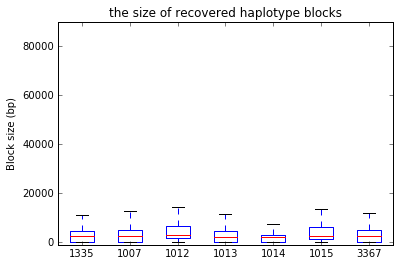

In [12]:
#boxplotting the size of recovered haplotype blocks. 
vcfs = []
for i in range(len(vcfFileNames)):
    vcfs.append(vcfparser.VCF(vcfroot+vcfFileNames[i]))

blocksizes = []    
for i in range(len(vcfFileNames)):
    blocksize = []
    for key in vcfs[i].hapDict.keys():
        block = vcfs[i].hapDict[key]
        _max = max(block, key=lambda x: x.pos)
        _min = min(block, key=lambda x: x.pos)
        blocksize.append(_max.pos-_min.pos)
    blocksizes.append(blocksize)

plt.figure()
plt.boxplot(blocksizes, 0, '')
plt.title("the size of recovered haplotype blocks")
plt.xticks([1, 2, 3, 4, 5, 6, 7], strainIDs)
plt.ylabel('Block size (bp)')
plt.ylim([-1000, 90000])
plt.show()

In [13]:
#Histogram of the size of recovered haplotype blocks 
def plot_recovered_haploblock_size(filename):
    vcf1 = vcfparser.VCF(vcfroot+filename)

    sizes = []
    for key in vcf1.hapDict.keys():
        block = vcf1.hapDict[key]
        _max = max(block,key=lambda item:item.pos).pos
        _min = min(block,key=lambda item:item.pos).pos
        sizes.append(_max-_min)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.hist(sizes, bins=100, alpha=0.75)
    ax.set_yscale('log')
    plt.title("Recovered block size of "+filename)
    plt.xlabel("block size (bp)")
    plt.ylabel("number of blocks (log scale)")
    plt.show()
    
#plot_recovered_haploblock_size(vcfFileNames[0])

=======../../vcf/GATK/1335full_phased.vcf=======
#SNPs: 166939
#INDELs: 8634
#VARs: 175573
#HAPBLOCKs: 27724
AVG SNP DEPTH: 78.9326377063
TOTAL LENGTH COVERED: 22884028 bps



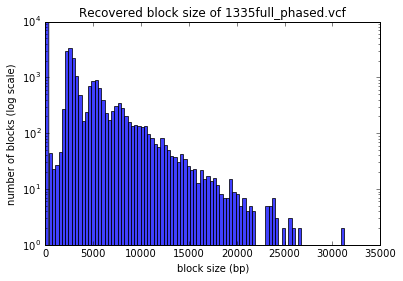

In [14]:
plot_recovered_haploblock_size(vcfFileNames[0])

=======../../vcf/GATK/IT_phased.vcf=======
#SNPs: 266584
#INDELs: 13112
#VARs: 279696
#HAPBLOCKs: 23241
AVG SNP DEPTH: 46.7624277787
TOTAL LENGTH COVERED: 25769954 bps



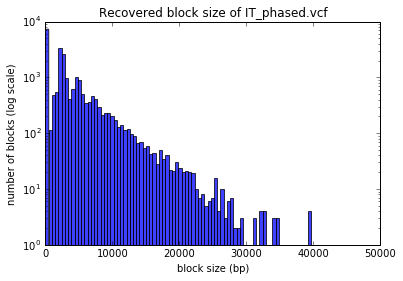

In [15]:
#Histogram of the size of recovered haplotype blocks 
plot_recovered_haploblock_size(vcfFileNames[6])

In [16]:
#plotting pair length
def plot_pair_dict(filename):
    pairdict = loaddict(filename)
    length = []

    for key in pairdict.keys():
        pairs = pairdict[key]
        for p in pairs:
            size = p[1]-p[0]
            length.append(size)

    plt.figure()
    plt.title("Pair size of "+filename)
    plt.xlabel("Pair size (bp)")
    plt.ylabel("number of Pairs")
    plt.hist(length, bins=100)
    plt.show()

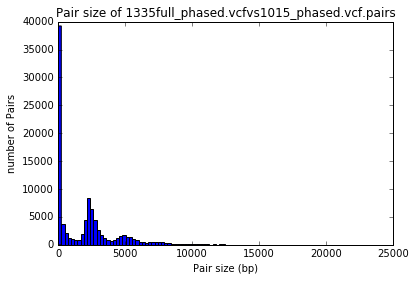

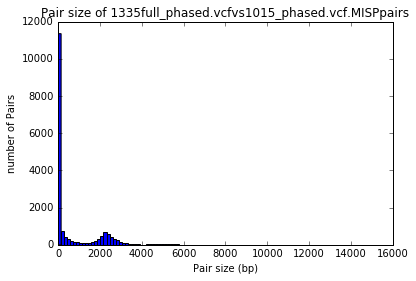

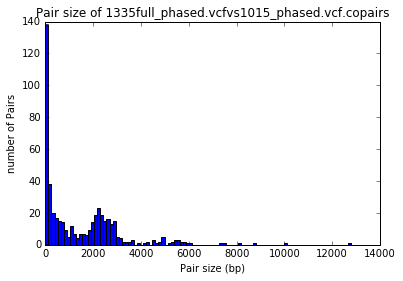

In [17]:
#1335 vs 1015
#common pairs 
plot_pair_dict("1335full_phased.vcfvs1015_phased.vcf.pairs")
#non-overlapping pairs 
plot_pair_dict("1335full_phased.vcfvs1015_phased.vcf.MISPpairs")
#crossover detected pairs
plot_pair_dict("1335full_phased.vcfvs1015_phased.vcf.copairs")

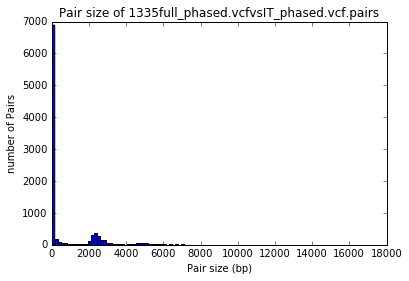

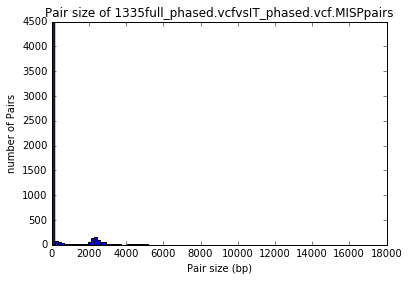

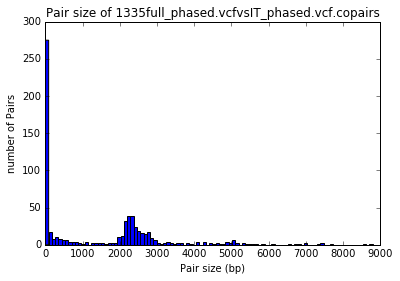

In [18]:
#1335 vs IT
#common pairs 
plot_pair_dict("1335full_phased.vcfvsIT_phased.vcf.pairs")
#non-overlapping pairs 
plot_pair_dict("1335full_phased.vcfvsIT_phased.vcf.MISPpairs")
#crossover detected pairs
plot_pair_dict("1335full_phased.vcfvsIT_phased.vcf.copairs")

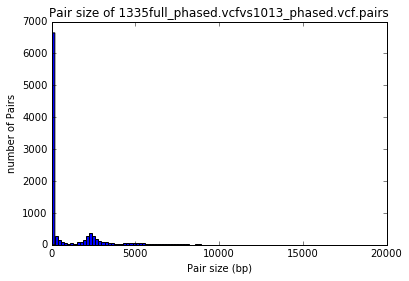

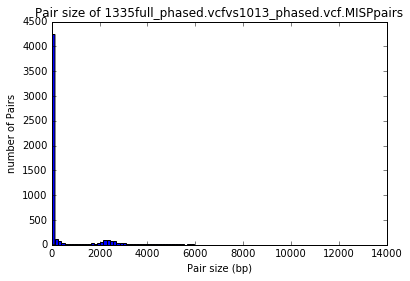

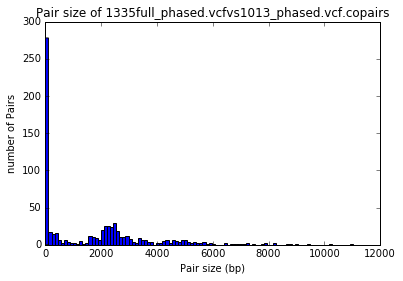

In [19]:
#1335 vs IT
#common pairs 
plot_pair_dict("1335full_phased.vcfvs1013_phased.vcf.pairs")
#non-overlapping pairs 
plot_pair_dict("1335full_phased.vcfvs1013_phased.vcf.MISPpairs")
#crossover detected pairs
plot_pair_dict("1335full_phased.vcfvs1013_phased.vcf.copairs")

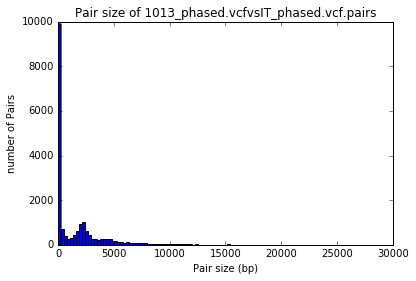

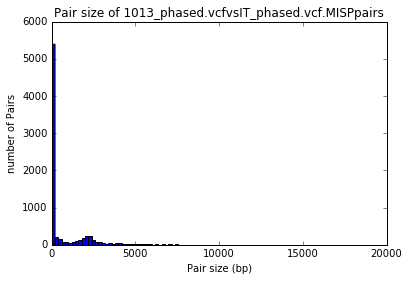

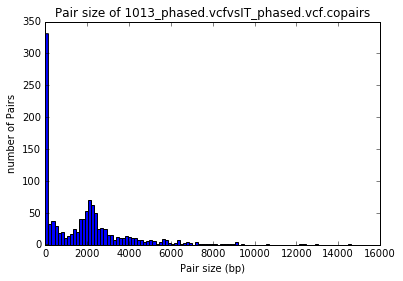

In [20]:
#1335 vs IT
#common pairs 
plot_pair_dict("1013_phased.vcfvsIT_phased.vcf.pairs")
#non-overlapping pairs 
plot_pair_dict("1013_phased.vcfvsIT_phased.vcf.MISPpairs")
#crossover detected pairs
plot_pair_dict("1013_phased.vcfvsIT_phased.vcf.copairs")

In [21]:
vcf1335 = vcfparser.VCF(vcfroot+"1335full_phased.vcf")
vcf1007 = vcfparser.VCF(vcfroot+"1007_phased.vcf")
vcf1012 = vcfparser.VCF(vcfroot+"1012_phased.vcf")
vcf1013 = vcfparser.VCF(vcfroot+"1013_phased.vcf")
vcf1014 = vcfparser.VCF(vcfroot+"1014_phased.vcf")
vcf1015 = vcfparser.VCF(vcfroot+"1015_phased.vcf")
vcfIT = vcfparser.VCF(vcfroot+"IT_phased.vcf")

=======../../vcf/GATK/1335full_phased.vcf=======
#SNPs: 166939
#INDELs: 8634
#VARs: 175573
#HAPBLOCKs: 27724
AVG SNP DEPTH: 78.9326377063
TOTAL LENGTH COVERED: 22884028 bps

=======../../vcf/GATK/1007_phased.vcf=======
#SNPs: 127221
#INDELs: 6114
#VARs: 133335
#HAPBLOCKs: 17129
AVG SNP DEPTH: 31.2347845652
TOTAL LENGTH COVERED: 21074161 bps

=======../../vcf/GATK/1012_phased.vcf=======
#SNPs: 133119
#INDELs: 7099
#VARs: 140218
#HAPBLOCKs: 12206
AVG SNP DEPTH: 55.4267283801
TOTAL LENGTH COVERED: 22834488 bps

=======../../vcf/GATK/1013_phased.vcf=======
#SNPs: 225281
#INDELs: 11471
#VARs: 236752
#HAPBLOCKs: 19570
AVG SNP DEPTH: 49.9257197405
TOTAL LENGTH COVERED: 27558517 bps

=======../../vcf/GATK/1014_phased.vcf=======
#SNPs: 71266
#INDELs: 2285
#VARs: 73551
#HAPBLOCKs: 11309
AVG SNP DEPTH: 26.0904950307
TOTAL LENGTH COVERED: 13439146 bps

=======../../vcf/GATK/1015_phased.vcf=======
#SNPs: 137099
#INDELs: 7461
#VARs: 144560
#HAPBLOCKs: 12428
AVG SNP DEPTH: 50.858065855
TOTAL LENGTH C

In [22]:
vcfobjects = [vcf1335, vcf1007, vcf1012, vcf1013, vcf1014, vcf1015, vcfIT]

In [25]:
#obtaining crossover desnity values. 
def compareStrains_from_saved_data(name1, name2, vcf1, vcf2):
    print "--------------------------------------------"
    print "Comparing "+ name1 + " vs " + name2
    dmy, result, dmy, dmy = compare(loaddict(name1+"vs"+name2+".MISPpairs"), vcf1, vcf2, verbose=False)
    return result

In [26]:
rates = [[0 for x in range(len(vcfobjects))] for x in range(len(vcfobjects))]
for i in range(len(vcfFileNames)):
    for j in range(i+1, len(vcfFileNames)):
        rates[i][j] = compareStrains_from_saved_data(vcfFileNames[i],vcfFileNames[j],vcfobjects[i],vcfobjects[j])
        
print rates                                 

--------------------------------------------
Comparing 1335full_phased.vcf vs 1007_phased.vcf
Total
AVG pair size: 682.036803966
# of crossover: 323
# of pairs examined: 15732
Length of genome examined: 10729803
Density for: 0.0000301031
--------------------------------------------
Comparing 1335full_phased.vcf vs 1012_phased.vcf
Total
AVG pair size: 782.553774215
# of crossover: 470
# of pairs examined: 16467
Length of genome examined: 12886313
Density for: 0.0000364728
--------------------------------------------
Comparing 1335full_phased.vcf vs 1013_phased.vcf
Total
AVG pair size: 567.111278479
# of crossover: 711
# of pairs examined: 5311
Length of genome examined: 3011928
Density for: 0.0002360614
--------------------------------------------
Comparing 1335full_phased.vcf vs 1014_phased.vcf
Total
AVG pair size: 446.091361437
# of crossover: 227
# of pairs examined: 7235
Length of genome examined: 3227471
Density for: 0.0000703337
--------------------------------------------
Compari

# Plotting the estimated crossover density vs when the strains were sampled. 
This Obviously shows an interesting trend between the density of crossover discovered vs when the strains were sampled. It is notable that 1013 seems to deviate from the trend perhaps due to the fact that the strain is sexually reproducing in wild. However, IT(3367) does seem to follow the trend. Let me see how this plot works out again after FDR correction.

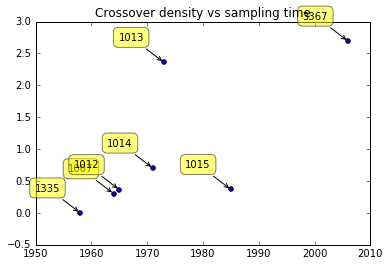

In [27]:
labels = strainIDs
xs = [1958, 1964, 1965, 1973, 1971, 1985, 2006]
ys = [i*10000 for i in rates[0]]

plt.figure()
plt.title("Crossover density vs sampling time")
plt.scatter(xs, ys)
for label, x, y in zip(labels, xs, ys):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()

# Does Pooling bamfiles for L-clade help reduce the number of co detected?
We would like to show (assuming that our no sex hypothesis is true) that the difference between L-clade is H-clade far bigger than 5-10 fold incrase in crossover density. The most obvious reason why we dont see bigger discrepancy is because of the false discoveries. Under the assumption that all L-clade strains are clonal, if we pool 1007 and 1012 together, and compare it against 1015 and 1335 pooled together, we might get higher cofidence values on SNP calls which will lead to less falsely discovered crossovers. Furthermore, bigger haplotype blocks will give us more crossover pairs to analyze.

Whitin Lclade: 0.00003676589950960517 (1335vs1015 for example) --> 0.00010685082500084356 
- 3-fold increase. This might suggest that they should not be pooled together as they are actually different because of mitotic crossover events.

Lclade vs IT: 0.00026938825167024667 --> 0.00019916662077574022

Lclade vs 1013: 0.00023606141979489549 --> 0.00024184106854442441

These values suggest that pooling might not be the best idea even within the likely clonal population because they still mitotically crossover at a very slow rate. 

In [76]:
#comparing pooled vcfs.
'''
compareStrains(vcfroot+"10071012_chr1_phased.vcf",vcfroot+"10151335_chr1_phased.vcf")
compareStrains(vcfroot+"Lclade_chr1_phased.vcf",vcfroot+"IT_chr1_phased.vcf")
compareStrains(vcfroot+"Lclade_chr1_phased.vcf",vcfroot+"1013_chr1_phased.vcf")
'''
vcf10071012chr1 = vcfparser.VCF(vcfroot+"10071012_chr1_phased.vcf")
vcf10151335chr1 = vcfparser.VCF(vcfroot+"10151335_chr1_phased.vcf")
vcfLchr1 = vcfparser.VCF(vcfroot+"Lclade_chr1_phased.vcf")
vcfITchr1 = vcfparser.VCF(vcfroot+"IT_chr1_phased.vcf")
vcf1013chr1 = vcfparser.VCF(vcfroot+"1013_chr1_phased.vcf")

=======/scratch/thaps_data/phasedvcfs/10071012_chr1_phased.vcf=======
#SNPs: 13151
#INDELs: 715
#VARs: 13866
#HAPBLOCKs: 832
AVG SNP DEPTH: 72.2178710515
TOTAL LENGTH COVERED: 2400933 bps

=======/scratch/thaps_data/phasedvcfs/10151335_chr1_phased.vcf=======
#SNPs: 16941
#INDELs: 908
#VARs: 17849
#HAPBLOCKs: 979
AVG SNP DEPTH: 95.3342484173
TOTAL LENGTH COVERED: 2479660 bps

=======/scratch/thaps_data/phasedvcfs/Lclade_chr1_phased.vcf=======
#SNPs: 16237
#INDELs: 853
#VARs: 17090
#HAPBLOCKs: 384
AVG SNP DEPTH: 87.6688706846
TOTAL LENGTH COVERED: 2494977 bps

=======/scratch/thaps_data/phasedvcfs/IT_chr1_phased.vcf=======
#SNPs: 26547
#INDELs: 1295
#VARs: 27842
#HAPBLOCKs: 2363
AVG SNP DEPTH: 46.2605057108
TOTAL LENGTH COVERED: 2616291 bps

=======/scratch/thaps_data/phasedvcfs/1013_chr1_phased.vcf=======
#SNPs: 22853
#INDELs: 1116
#VARs: 23969
#HAPBLOCKs: 2032
AVG SNP DEPTH: 48.5991071801
TOTAL LENGTH COVERED: 2755752 bps



In [78]:
compareStrains_from_saved_data("10071012_chr1_phased.vcf", "10151335_chr1_phased.vcf", vcf10071012chr1, vcf10151335chr1)
compareStrains_from_saved_data("Lclade_chr1_phased.vcf", "IT_chr1_phased.vcf", vcfLchr1, vcfITchr1)
compareStrains_from_saved_data("Lclade_chr1_phased.vcf", "1013_chr1_phased.vcf", vcfLchr1, vcf1013chr1)

--------------------------------------------
Comparing 10071012_chr1_phased.vcf vs 10151335_chr1_phased.vcf
Total
AVG pair size: 632.804270463
# of crossover: 228
# of pairs examined: 3372
Length of genome examined: 2133816
Density for: 0.00010685082500084356
--------------------------------------------
Comparing Lclade_chr1_phased.vcf vs IT_chr1_phased.vcf
Total
AVG pair size: 1261.04166667
# of crossover: 217
# of pairs examined: 864
Length of genome examined: 1089540
Density for: 0.00019916662077574022
--------------------------------------------
Comparing Lclade_chr1_phased.vcf vs 1013_chr1_phased.vcf
Total
AVG pair size: 1149.49901768
# of crossover: 283
# of pairs examined: 1018
Length of genome examined: 1170190
Density for: 0.00024184106854442441


0.0002418410685444244

#Checking depth of pairs where a crossover event is detected.
The crossover event might have been driven by gene duplication; GATK readbackedphasing might get confused when constructing haplotypeblocks on the gonome region that is repeated. See if the coverage of SNP pairs who have a crossover events have unusual coverage such as 0.5x or 2x average. 

There is no particular cluster at around 0.5x or 2x coverage, suggesting that gene duplication and hemizygosity is not an issue.

In [28]:
def examine_pair_depth(strain1, strain2, vcf1, vcf2):
    cv_pairs = loaddict(strain1+"vs"+strain2+".copairs")
    pair_depth_1 = ([],[])
    pair_depth_2 = ([],[])
    
    name1 = strain1.split("_")[0]
    name2 = strain2.split("_")[0]
        
    for key in cv_pairs.keys():
        cur_chrom = cv_pairs[key]
        
        for p in cur_chrom:
            x1 = vcf1.variants_dict[(key, p[0])].info["DP"]
            y1 = vcf1.variants_dict[(key, p[1])].info["DP"]
            
            x2 = vcf2.variants_dict[(key, p[0])].info["DP"]
            y2 = vcf2.variants_dict[(key, p[1])].info["DP"]

            pair_depth_1[0].append(x1)
            pair_depth_1[1].append(y1)

            pair_depth_2[0].append(x2)
            pair_depth_2[1].append(y2)
            
    p1 = pair_depth_1
    p2 = pair_depth_2

    #plotting depth pairs.
    plt.figure()
    plt.title("Depth of co pairs of "+name1+" in "+name1+" vs "+name2)
    plt.xlabel("Depth(SNP1)")
    plt.ylabel("Depth(SNP2)")
    plt.plot(p1[0],p1[1], '.', color=[1,0,0,1])
    plt.plot([vcf1.avgDEPTH], [vcf1.avgDEPTH], "o", color=[1,1,1,1])
    plt.show()

    #plotting depth pairs.
    plt.figure()
    plt.title("Depth of co pairs of "+name2+" in "+name1+" vs "+name2)
    plt.xlabel("Depth(SNP1)")
    plt.ylabel("Depth(SNP2)")
    plt.plot(p2[0],p2[1], '.', color=[1,0,0,1])
    plt.plot([vcf2.avgDEPTH], [vcf2.avgDEPTH], "o", color=[1,1,1,1])
    plt.show()

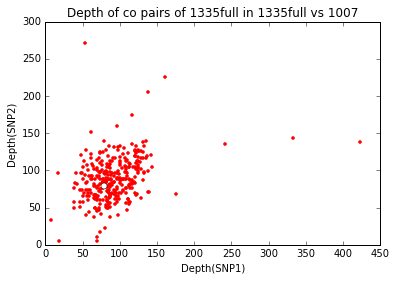

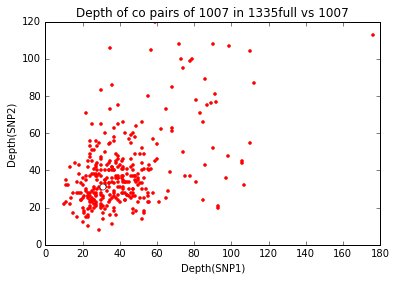

In [29]:
examine_pair_depth("1335full_phased.vcf", "1007_phased.vcf", vcf1335, vcf1007)

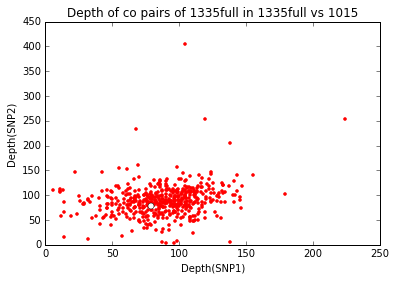

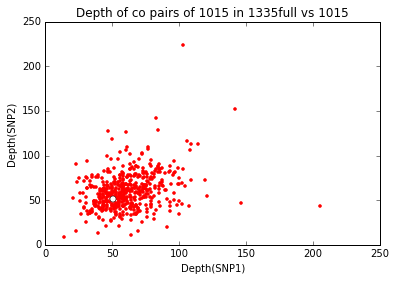

In [30]:
examine_pair_depth("1335full_phased.vcf", "1015_phased.vcf", vcf1335, vcf1015)

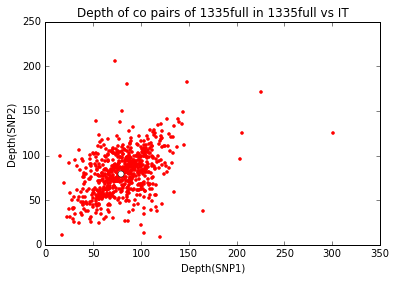

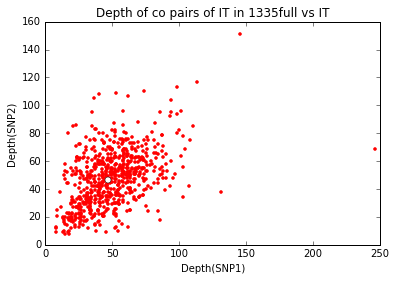

In [31]:
examine_pair_depth("1335full_phased.vcf", "IT_phased.vcf", vcf1335, vcfIT)

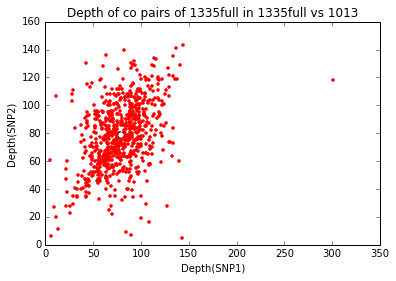

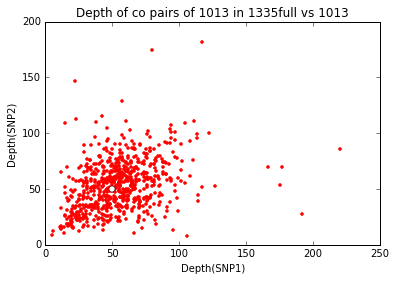

In [32]:
examine_pair_depth("1335full_phased.vcf", "1013_phased.vcf", vcf1335, vcf1013)

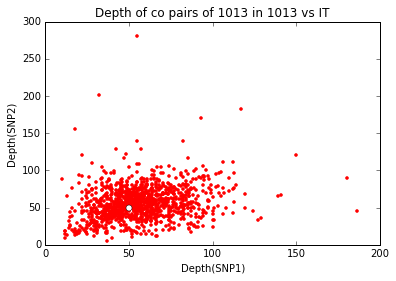

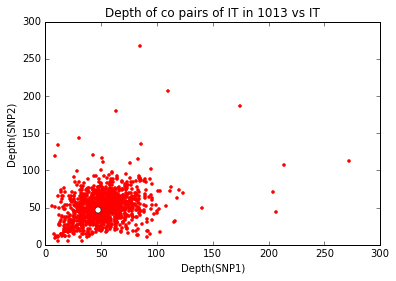

In [33]:
examine_pair_depth("1013_phased.vcf", "IT_phased.vcf", vcf1013, vcfIT)

#Checking for FDR of crossover events.
There ways that one can determine FDR of the crossover discovery algorithms.

- By checking overlapping pairs: Let us say that there are two pairs $p_i$ and $p_j$, and $p_j$ completely encapsulates $p_i$. If $len(p_i) - len(p_j)$ is less than some threshold, see wheater the crossover calls for $p_i$ and $p_j$ diagrees. The stricter threshold will of course lead to more precise FDR but less sample size.
- By simulation: we can simulate how many crossover events are necessary to obtain the observed # crossover given the pairs examined. 

# Checking FDR by looking at overlapping pairs.

In [34]:
#find encapsulating pairs.
#pairs: you can get this from .pairs files.
#MISPpairs: you can get this from .MISPpairs files.

def find_min_overlapping_pairs(pairs, MISPpairs):
    ret = {}
    
    for key in pairs.keys():
        dic1 = pairs[key]
        dic2 = MISPpairs[key]
        solution = []
        for p in dic2:
            temp = find_overlapping_pair_inner(p, dic1)
            if temp:
                solution.append((p, temp[0], temp[1]))
        ret[key] = solution

    return ret

#This function returns a tuple like this --> (pair, immediate_overlapping_pair, list_of_overlapping_pairs)
def find_overlapping_pair_inner(p, pairs):
    #find overlapping pairs 
    temp = []
    for i in pairs:
        if i[0]<p[0] and i[1]>p[1]:
            temp.append(i)

    if len(temp)==0:
        return False

    #find minimum out of the pairs
    minp = temp[0]
    for i in range(1, len(temp)):
        if temp[i][1]-temp[i][0] < minp[1]-minp[0]:
            minp = temp[i]
    ret = (minp, temp)
    return ret

In [35]:
#find encapsulating pairs.
#pairs: you can get this from .pairs files.
#MISPpairs: you can get this from .MISPpairs files.

#This makes sure that the overlapping pairs are not from the same block. 

def find_min_overlapping_pairs2(pairs, MISPpairs, vcf1, vcf2):
    ret = {}
    
    for key in pairs.keys():
        #print key
        dic1 = pairs[key]
        dic2 = MISPpairs[key]
        solution = []
        for p in dic2:
            temp = find_overlapping_pair_inner2(p, dic1, vcf1, vcf2, key)
            if temp:
                solution.append((p, temp[0], temp[1]))
        ret[key] = solution

    return ret

#This function returns a tuple like this --> (pair, immediate_overlapping_pair, list_of_overlapping_pairs)
def find_overlapping_pair_inner2(p, pairs, vcf1, vcf2, chrom):
    #print p
    #find overlapping pairs 
    temp = []
    for i in pairs:
        #make sure that i contains 
        if i[0]<p[0] and i[1]>p[1]:
            block1 = vcf1.getHapBlockByPos(chrom,p[0])
            block2 = vcf2.getHapBlockByPos(chrom,p[0])
            if not(i[0] in block1) or not(i[0] in block2):
                temp.append(i)

    if len(temp)==0:
        return False

    #find minimum out of the pairs
    minp = temp[0]
    for i in range(1, len(temp)):
        if temp[i][1]-temp[i][0] < minp[1]-minp[0]:
            minp = temp[i]
    ret = (minp, temp)
    return ret

In [37]:
pairs = loaddict("1335full_phased.vcfvs1007_phased.vcf.pairs")
MISPpairs = loaddict("1335full_phased.vcfvs1007_phased.vcf.MISPpairs")
#find_min_overlapping_pairs2(pairs, MISPpairs, vcf1335, vcf1007)

In [38]:
#This function discovers if the calls for inner pairs agree with those of outer pairs.
#It only checks for the immediate outer pair unlike checkFD2
def checkFD(pairs, vcf1, vcf2, th=None):
    result = []
    
    tot_FP = 0
    tot_TP = 0
    tot_FN = 0
    tot_TN = 0
    tot_pairs = 0
    
    for key in pairs.keys():
        if key[:2] != "BD":
            dic = pairs[key]
            for i in dic:
                p = i[0]
                p2 = i[1]

                if th == None:
                    th = int("inf")
                if (p2[1]-p2[0])-(p[1]-p[0]) < th:
                
                    v0a = vcf1.getVariant(key, p[0])
                    v1a = vcf1.getVariant(key, p[1])
                    v0b = vcf2.getVariant(key, p[0])
                    v1b = vcf2.getVariant(key, p[1])
                    ret1 = isCrossOver(v0a,v1a,v0b,v1b)

                    v0a = vcf1.getVariant(key, p2[0])
                    v1a = vcf1.getVariant(key, p2[1])
                    v0b = vcf2.getVariant(key, p2[0])
                    v1b = vcf2.getVariant(key, p2[1])
                    ret2 = isCrossOver(v0a,v1a,v0b,v1b)

                    #result does not matche
                    if ret1 == 1 and ret2 == 0:
                        tot_FP += 1
                        ans = False
                    elif ret1 == 1 and ret2 == 1:
                        tot_TP += 1
                        ans = True
                    elif ret1 == 0 and ret2 == 1:
                        tot_FN += 1
                        ans = False
                    elif ret1 == 0 and ret2 == 0:
                        tot_TN += 1
                        ans = True
                    tot_pairs += 1

                    result.append((i, ans))

    print "# false positives", tot_FP
    print "# true positives", tot_TP
    print "# false negatives", tot_FN
    print "# true negatives", tot_TN
    print "# pairs examined", tot_pairs

    return result, (tot_FP, tot_TP, tot_FN, tot_TN, tot_pairs)

#This function discovers if the calls for inner pairs agree with those of outer pairs.
#It only checks for every singler inner-outer pair combination.
def checkFD2(pairs, vcf1, vcf2):
    result = []
    
    tot_FP = 0
    tot_TP = 0
    tot_FN = 0
    tot_TN = 0
    tot_pairs = 0
    
    for key in pairs.keys():
        if key[:2] != "BD":
            dic = pairs[key]
            for i in dic:
                p = i[0]
                temp = i[2]

                for p2 in temp:
                
                    v0a = vcf1.getVariant(key, p[0])
                    v1a = vcf1.getVariant(key, p[1])
                    v0b = vcf2.getVariant(key, p[0])
                    v1b = vcf2.getVariant(key, p[1])
                    ret1 = isCrossOver(v0a,v1a,v0b,v1b)

                    v0a = vcf1.getVariant(key, p2[0])
                    v1a = vcf1.getVariant(key, p2[1])
                    v0b = vcf2.getVariant(key, p2[0])
                    v1b = vcf2.getVariant(key, p2[1])
                    ret2 = isCrossOver(v0a,v1a,v0b,v1b)

                    #result does not matche
                    if ret1 == 1 and ret2 == 0:
                        tot_FP += 1
                        ans = 0
                    elif ret1 == 1 and ret2 == 1:
                        tot_TP += 1
                        ans = 1
                    elif ret1 == 0 and ret2 == 1:
                        tot_FN += 1
                        ans = 0
                    elif ret1 == 0 and ret2 == 0:
                        tot_TN += 1
                        ans = 1
                    tot_pairs += 1

                    result.append(((p, p2), ans))

    print "# false positives", tot_FP
    print "# true positives", tot_TP
    print "# false negatives", tot_FN
    print "# true negatives", tot_TN
    print "# pairs examined", tot_pairs

    return result

In [39]:
#This function analyzes the ratio of true/false calls for different size of pairs.
def analyze_false_call_ratio(result, verbose=True):
    data = [ [0, 0] for x in range(20)]
    for i in result:
        pair1 = i[0][0]
        pair2 = i[0][1]
        ans = i[1]

        dif = (pair2[1]-pair2[0])- (pair1[1]-pair1[0])
        index = dif/1000
        if index < len(data):
            data[index][ans] += 1
            
    ret = [0.0 for i in range(len(data))]
    for i in range(len(data)):
        if data[i][1]+data[i][0] != 0:
            if verbose: print str(data[i][0]*1.0/(data[i][1]+data[i][0]))+" : ",
            else: ret[i] = data[i][0]*1.0/(data[i][1]+data[i][0])
        else:
            if verbose: print "0.0 : "
        if verbose: print str(i*1000)+"~"+str((i+1)*1000), "(", data[i][0], data[i][1], ")"
    return ret

In [40]:
#plotting the difference between minimum pairs and overlapping pairs.
def plot_difference_inner_outer_pairs(pairs):
    temp = []
    for k in pairs.keys():
        ls = pairs[k]
        for i in ls:
            temp.append(((i[1][1]-i[1][0])-(i[0][1]-i[0][0])))

    fig = plt.figure()
    plt.ylabel("# of inner-outer pairs")
    plt.xlabel("difference in size (bp)")
    ax = fig.add_subplot(111)
    plt.hist(temp, bins=100, alpha=0.75)
    plt.show()

In [41]:
def analyze_size_difference(strain1, strain2):
    name1 = strain1.split("_")[0]
    name2 = strain2.split("_")[0]
    print "-------------------------"
    print "Analyzing the size difference"+ name1 + " vs " + name2 
    filename_base = strain1+"vs"+strain2
    pairs = loaddict(filename_base+".pairs")
    MISPpairs = loaddict(filename_base+".MISPpairs")
    result = find_min_overlapping_pairs(pairs, MISPpairs)
    plot_difference_inner_outer_pairs(result)

-------------------------
Analyzing the size difference1335full vs 1007


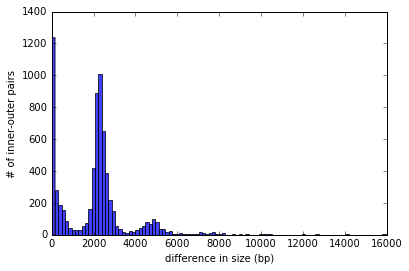

In [42]:
analyze_size_difference("1335full_phased.vcf", "1007_phased.vcf")

-------------------------
Analyzing the size difference1335full vs IT


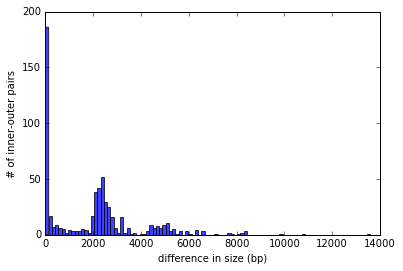

In [43]:
analyze_size_difference("1335full_phased.vcf", "IT_phased.vcf")

-------------------------
Analyzing the size difference1335full vs 1013


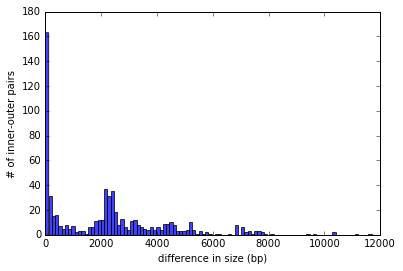

In [44]:
analyze_size_difference("1335full_phased.vcf", "1013_phased.vcf")

-------------------------
Analyzing the size difference1013 vs IT


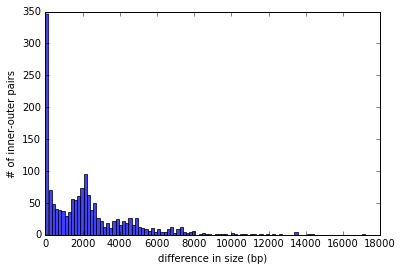

In [45]:
analyze_size_difference("1013_phased.vcf", "IT_phased.vcf")

In [46]:
#This function is a wrapper for other FDR analysis functions
def analyze_FDR_1(strain1, strain2, vcf1, vcf2):
    name1 = strain1.split("_")[0]
    name2 = strain2.split("_")[0]
    print "-------------------------"
    print "Analyzing "+ name1 + " vs " + name2 
    filename_base = strain1+"vs"+strain2
    pairs = loaddict(filename_base+".pairs")
    MISPpairs = loaddict(filename_base+".MISPpairs")
    result = find_min_overlapping_pairs(pairs, MISPpairs)
    result2 = checkFD2(result, vcf1, vcf2)
    plt.figure()
    plt.ylabel("proportion false call")
    plt.xlabel("difference in size (bp)")
    ax = plt.subplot(111)
    data = [int(x*100) for x in analyze_false_call_ratio(result2,verbose=False)]
    ax.bar([x*0.35 for x in range(len(data))], data, width=0.3,color='b',align='center')
    #plt.xticks(len(data) + 0.35, range(len(data)*1000))
    plt.show()

-------------------------
Analyzing 1335full vs 1007
# false positives 835
# true positives 438
# false negatives 2190
# true negatives 43636
# pairs examined 47166


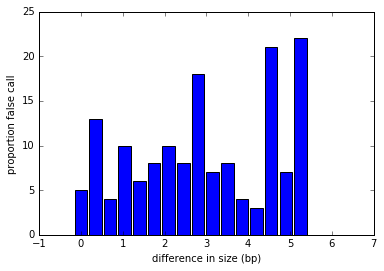

-------------------------
Analyzing 1335full vs 1012
# false positives 3826
# true positives 1968
# false negatives 8256
# true negatives 109420
# pairs examined 123488


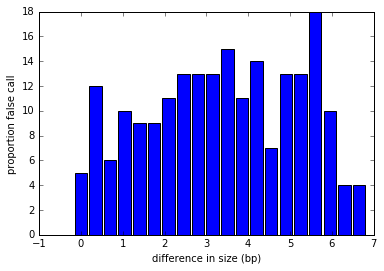

-------------------------
Analyzing 1335full vs 1013
# false positives 231
# true positives 240
# false negatives 625
# true negatives 1310
# pairs examined 2462


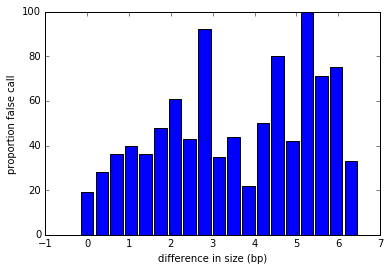

-------------------------
Analyzing 1335full vs 1014
# false positives 63
# true positives 43
# false negatives 162
# true negatives 1976
# pairs examined 2244


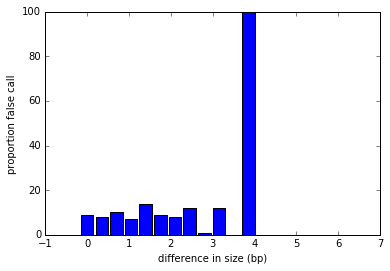

-------------------------
Analyzing 1335full vs 1015
# false positives 3833
# true positives 2034
# false negatives 9808
# true negatives 105499
# pairs examined 121230


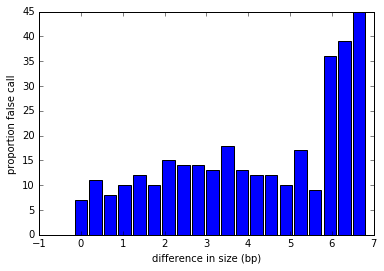

-------------------------
Analyzing 1335full vs IT
# false positives 78
# true positives 106
# false negatives 414
# true negatives 819
# pairs examined 1489


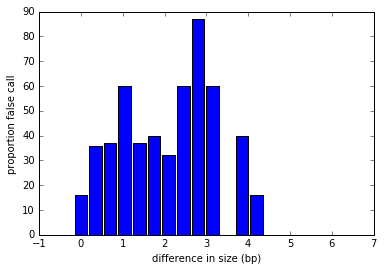

-------------------------
Analyzing 1007 vs 1012
# false positives 13946
# true positives 10267
# false negatives 43106
# true negatives 491477
# pairs examined 559533


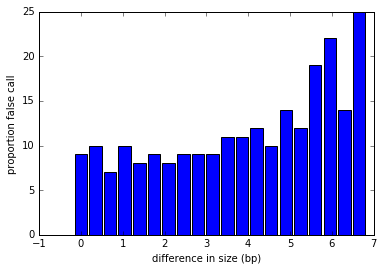

-------------------------
Analyzing 1007 vs 1013
# false positives 456
# true positives 393
# false negatives 1662
# true negatives 3888
# pairs examined 6563


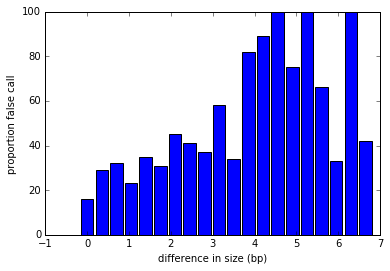

-------------------------
Analyzing 1007 vs 1014
# false positives 163
# true positives 120
# false negatives 478
# true negatives 4411
# pairs examined 5173


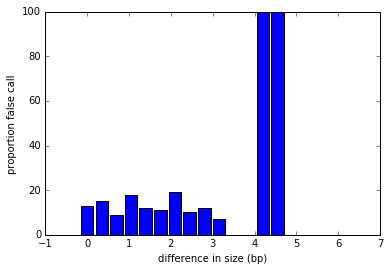

-------------------------
Analyzing 1007 vs 1015
# false positives 35385
# true positives 30184
# false negatives 82341
# true negatives 495226
# pairs examined 643335


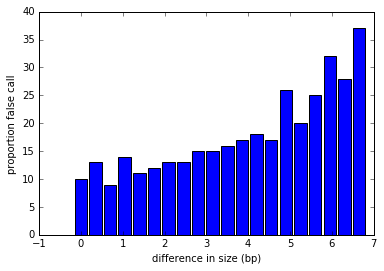

-------------------------
Analyzing 1007 vs IT
# false positives 257
# true positives 250
# false negatives 825
# true negatives 2054
# pairs examined 3446


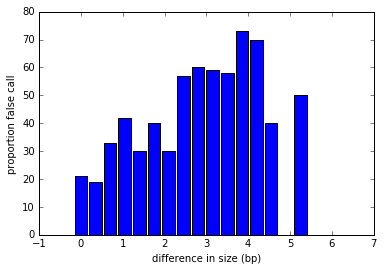

-------------------------
Analyzing 1012 vs 1013
# false positives 2060
# true positives 2215
# false negatives 9165
# true negatives 15878
# pairs examined 29915


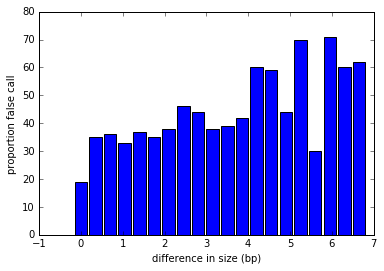

-------------------------
Analyzing 1012 vs 1014
# false positives 1086
# true positives 410
# false negatives 1901
# true negatives 19127
# pairs examined 22524


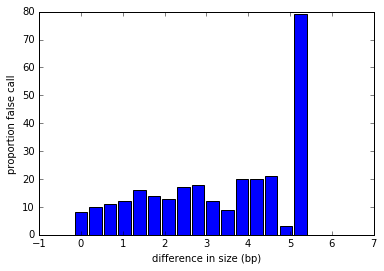

-------------------------
Analyzing 1012 vs 1015
# false positives 131267
# true positives 86699
# false negatives 335718
# true negatives 3104335
# pairs examined 3660516


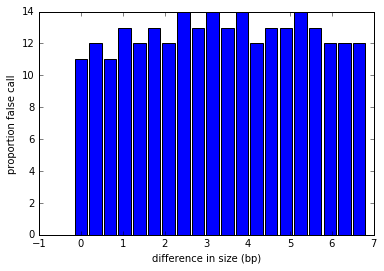

-------------------------
Analyzing 1012 vs IT
# false positives 949
# true positives 881
# false negatives 3229
# true negatives 6041
# pairs examined 11404


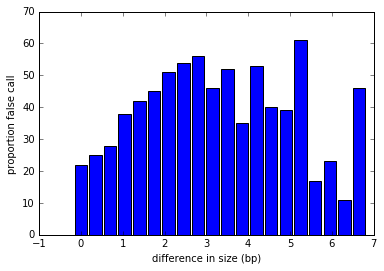

-------------------------
Analyzing 1013 vs 1014
# false positives 54
# true positives 66
# false negatives 235
# true negatives 220
# pairs examined 603


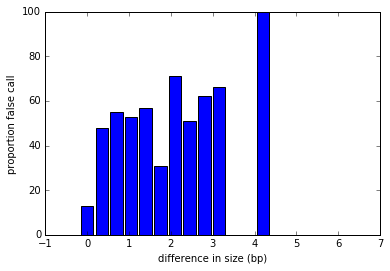

-------------------------
Analyzing 1013 vs 1015
# false positives 19099
# true positives 19664
# false negatives 62177
# true negatives 68107
# pairs examined 176916


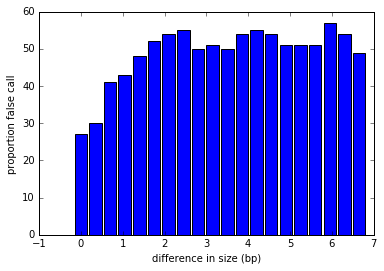

-------------------------
Analyzing 1013 vs IT
# false positives 1049
# true positives 1055
# false negatives 3180
# true negatives 5644
# pairs examined 11096


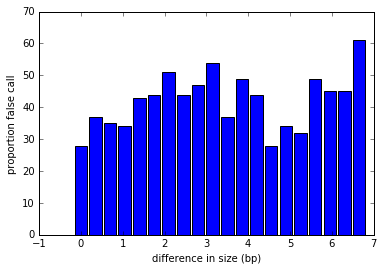

-------------------------
Analyzing 1014 vs 1015
# false positives 1585
# true positives 1111
# false negatives 3603
# true negatives 19220
# pairs examined 25572


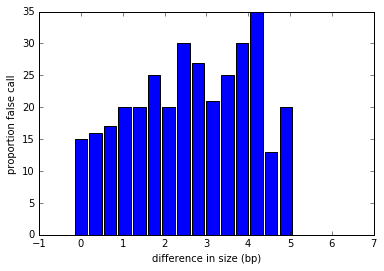

-------------------------
Analyzing 1014 vs IT
# false positives 14
# true positives 19
# false negatives 83
# true negatives 202
# pairs examined 333


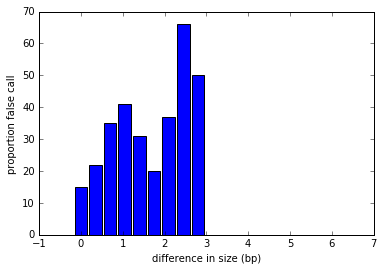

-------------------------
Analyzing 1015 vs IT
# false positives 1591
# true positives 1529
# false negatives 3868
# true negatives 6137
# pairs examined 13582


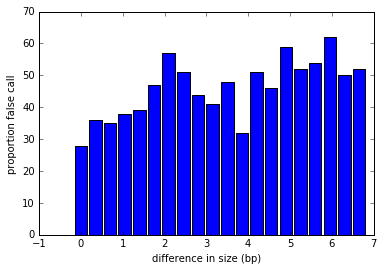

In [48]:
vcfobjects = [vcf1335, vcf1007, vcf1012, vcf1013, vcf1014, vcf1015, vcfIT]

for i in range(len(vcfFileNames)):
    for j in range(i+1, len(vcfFileNames)):
        analyze_FDR_1(vcfFileNames[i], vcfFileNames[j], vcfobjects[i], vcfobjects[j])

In [49]:
#This function is a wrapper for other FDR analysis functions
def analyze_FDR_2(strain1, strain2, vcf1, vcf2):
    name1 = strain1.split("_")[0]
    name2 = strain2.split("_")[0]
    print "-------------------------"
    print "Analyzing "+ name1 + " vs " + name2 
    filename_base = strain1+"vs"+strain2
    pairs = loaddict(filename_base+".pairs")
    MISPpairs = loaddict(filename_base+".MISPpairs")
    result = find_min_overlapping_pairs(pairs, MISPpairs)
    result2 = checkFD(result, vcf1, vcf2, 3000)

In [50]:
for i in range(len(vcfFileNames)):
    for j in range(i+1, len(vcfFileNames)):
        analyze_FDR_2(vcfFileNames[i], vcfFileNames[j], vcfobjects[i], vcfobjects[j])

-------------------------
Analyzing 1335full vs 1007
# false positives 90
# true positives 52
# false negatives 173
# true negatives 5624
# pairs examined 5948
-------------------------
Analyzing 1335full vs 1012
# false positives 150
# true positives 101
# false negatives 305
# true negatives 7175
# pairs examined 7736
-------------------------
Analyzing 1335full vs 1013
# false positives 28
# true positives 41
# false negatives 76
# true negatives 305
# pairs examined 460
-------------------------
Analyzing 1335full vs 1014
# false positives 17
# true positives 10
# false negatives 50
# true negatives 512
# pairs examined 589
-------------------------
Analyzing 1335full vs 1015
# false positives 167
# true positives 97
# false negatives 332
# true negatives 7554
# pairs examined 8151
-------------------------
Analyzing 1335full vs IT
# false positives 24
# true positives 33
# false negatives 96
# true negatives 293
# pairs examined 464
-------------------------
Analyzing 1007 vs 1012

=================
This needs to be re-investigated by not the highest priority

In [246]:
def analyze_FDR_3(strain1, strain2, vcf1, vcf2):
    name1 = strain1.split("_")[0]
    name2 = strain2.split("_")[0]
    print "-------------------------"
    print "Analyzing "+ name1 + " vs " + name2 
    filename_base = strain1+"vs"+strain2
    pairs = loaddict(filename_base+".pairs")
    MISPpairs = loaddict(filename_base+".MISPpairs")
    result = find_min_overlapping_pairs2(pairs, MISPpairs, vcf1, vcf2)
    savedict(result,filename_base+".FDR3")
    result2 = checkFD(result, vcf1, vcf2, 3000)
    return result2

In [247]:
results = []
for i in range(1):#len(vcfFileNames)):
    for j in range(i+1, len(vcfFileNames)):
        results.append(analyze_FDR_3(vcfFileNames[i], vcfFileNames[j], vcfobjects[i], vcfobjects[j]))

-------------------------
Analyzing 1335full vs 1007
# false positives 90
# true positives 52
# false negatives 173
# true negatives 5624
# pairs examined 5948
-------------------------
Analyzing 1335full vs 1012
# false positives 150
# true positives 101
# false negatives 305
# true negatives 7175
# pairs examined 7736
-------------------------
Analyzing 1335full vs 1013
# false positives 28
# true positives 41
# false negatives 76
# true negatives 305
# pairs examined 460
-------------------------
Analyzing 1335full vs 1014
# false positives 17
# true positives 10
# false negatives 50
# true negatives 512
# pairs examined 589
-------------------------
Analyzing 1335full vs 1015
# false positives 167
# true positives 97
# false negatives 332
# true negatives 7554
# pairs examined 8151
-------------------------
Analyzing 1335full vs IT
# false positives 24
# true positives 33
# false negatives 96
# true negatives 293
# pairs examined 464


# Simulating and correcting for even-number crossover by simulation

In [51]:
def weighted_choice(choices):
    total = sum(w for c, w in choices)
    r = random.uniform(0, total)
    upto = 0
    for c, w in choices:
        if upto + w > r:
            return c
        upto += w
    assert False, "Shouldn't get here"

def simulate_observable_crossover_number(MISPpairs, n_co, verbose=True):
    
    pairdict = loaddict(MISPpairs)
    choices = []

    _id = 1
    #each chromosome
    for key in pairdict.keys():
        if key[:3] == "Chr":
            pairs = pairdict[key]

            for p in pairs:
                size = p[1]-p[0]
                choices.append((_id,size))
                _id += 1

    countdict = {}
    #weighted sampling and counting
    for i in range(n_co):
        draw =  weighted_choice(choices)
        countdict[draw] = countdict.get(draw, 0)+1

    count = 0
    for k in countdict.keys():
        temp = countdict[k]
        count += temp%2
    
    if verbose:
        print "# of pairs examined:", len(choices)
        print "Observable crossover counts:", count
        print "Actual crossover counts:", n_co
    
    return count

def simulate_true_crossover_number(MISPpairs, observed, th=50, nsample=20, start=None, verbose=False):
    print "-----------------------------------------------------------------"
    print "Simulating the actual crossover # for " + MISPpairs
        
    result = []
    if start==None:
        cur_estimate = observed
    trial = 0
    
    while len(result) < nsample:
        trial +=1
        estimated_observed = simulate_observable_crossover_number(MISPpairs, cur_estimate, verbose=False)
        
        if estimated_observed < observed+th and estimated_observed > observed-th:
            if verbose: print "Trial", trial, ":", cur_estimate, "(success)"
            result.append(cur_estimate)
        else:
            if verbose: print "Trial", trial, ":", cur_estimate, "(failure)"
            
        cur_estimate += (observed-estimated_observed)
        
    print "Observed # crossover:", observed
    print "Actual # crossover:", sum(result)/len(result)
    return result

In [170]:
#Trying to find the actual number of crossovers.
simulate_true_crossover_number("1335full_phased.vcfvs1007_phased.vcf.MISPpairs", 323)
simulate_true_crossover_number("1335full_phased.vcfvs1012_phased.vcf.MISPpairs", 470)
simulate_true_crossover_number("1335full_phased.vcfvs1013_phased.vcf.MISPpairs", 711)
simulate_true_crossover_number("1335full_phased.vcfvs1014_phased.vcf.MISPpairs", 227)
simulate_true_crossover_number("1335full_phased.vcfvs1015_phased.vcf.MISPpairs", 496)
simulate_true_crossover_number("1335full_phased.vcfvsIT_phased.vcf.MISPpairs", 682)

-----------------------------------------------------------------
Simulating the actual crossover # for 1335full_phased.vcfvs1007_phased.vcf.MISPpairs
Observed # crossover: 323
Actual # crossover: 355
-----------------------------------------------------------------
Simulating the actual crossover # for 1335full_phased.vcfvs1012_phased.vcf.MISPpairs
Observed # crossover: 470
Actual # crossover: 529
-----------------------------------------------------------------
Simulating the actual crossover # for 1335full_phased.vcfvs1013_phased.vcf.MISPpairs
Observed # crossover: 711
Actual # crossover: 6114
-----------------------------------------------------------------
Simulating the actual crossover # for 1335full_phased.vcfvs1014_phased.vcf.MISPpairs
Observed # crossover: 227
Actual # crossover: 280
-----------------------------------------------------------------
Simulating the actual crossover # for 1335full_phased.vcfvs1015_phased.vcf.MISPpairs
Observed # crossover: 496
Actual # crossover

[5468,
 5716,
 6084,
 6108,
 6136,
 6232,
 6310,
 6344,
 6458,
 6494,
 6534,
 6578,
 6606,
 6710,
 6752,
 6760,
 6786,
 6820,
 6846,
 6942]

In [52]:
vcfobjects = [vcf1335, vcf1007, vcf1012, vcf1013, vcf1014, vcf1015, vcfIT]

density = np.zeros(len(vcfFileNames)*len(vcfFileNames)).reshape((len(vcfFileNames),len(vcfFileNames)))

for i in range(len(vcfFileNames)):
    for j in range(i+1, len(vcfFileNames)):
        print "---------------"
        print vcfFileNames[i]+"vs"+vcfFileNames[j]
        filename = vcfFileNames[i]+"vs"+vcfFileNames[j]+".MISPpairs"
        dmy, dmy, genomelength, co = compare(loaddict(filename),  vcfobjects[i], vcfobjects[j], verbose=False)
        result = simulate_true_crossover_number(filename, co)
        actualco = sum(result)/len(result)
        temp = int((actualco*1.0/genomelength)*1000000)*1.0/1000
        print "Actual crossover rate:", temp
        density[i,j] = temp

print temp

---------------
1335full_phased.vcfvs1007_phased.vcf
Total
AVG pair size: 682.036803966
# of crossover: 323
# of pairs examined: 15732
Length of genome examined: 10729803
Density for: 0.0000301031
-----------------------------------------------------------------
Simulating the actual crossover # for 1335full_phased.vcfvs1007_phased.vcf.MISPpairs
Observed # crossover: 323
Actual # crossover: 352
Actual crossover rate: 0.032
---------------
1335full_phased.vcfvs1012_phased.vcf
Total
AVG pair size: 782.553774215
# of crossover: 470
# of pairs examined: 16467
Length of genome examined: 12886313
Density for: 0.0000364728
-----------------------------------------------------------------
Simulating the actual crossover # for 1335full_phased.vcfvs1012_phased.vcf.MISPpairs
Observed # crossover: 470
Actual # crossover: 528
Actual crossover rate: 0.04
---------------
1335full_phased.vcfvs1013_phased.vcf
Total
AVG pair size: 567.111278479
# of crossover: 711
# of pairs examined: 5311
Length of gen

In [53]:
#density in matrix form. 
print density

[[ 0.     0.032  0.04   2.065  0.086  0.04   2.838]
 [ 0.     0.     0.043  1.26   0.058  0.041  2.33 ]
 [ 0.     0.     0.     1.028  0.056  0.066  1.714]
 [ 0.     0.     0.     0.     0.84   1.031  1.338]
 [ 0.     0.     0.     0.     0.     0.06   1.704]
 [ 0.     0.     0.     0.     0.     0.     1.757]
 [ 0.     0.     0.     0.     0.     0.     0.   ]]


# Looking at common SNPs acrooss all strains and how many unique crossovers are present in each strain.
Discovering the unique set of crossovers, and comparing it with the SNP tree.
Here is the SNP tree.

What did I do?
- I calculated crossover density based on common SNPs.
- There is no common CO-detected pairs that are common to all strains. The sample size is too small.

In [54]:
#Extracting common SNP among all strains except for 1014
def extractCommonSNPsAmongAllStrains(vcfobjects):
    
    #getting the chromosome value
    chrom = ['Chr1', 'Chr2', 'Chr3', 'Chr4', 'Chr5', 'Chr6', 'Chr7', 'Chr8', 'Chr9', 'Chr10', 'Chr11a', 'Chr11b', \
             'Chr12', 'Chr13', 'Chr14', 'Chr15', 'Chr16a', 'Chr16b', 'Chr17', 'Chr18', 'Chr19a_19', 'Chr19b_31', \
             'Chr19c_29', 'Chr20', 'Chr22', 'Chr23', 'Chr24', 'mitochondria.fasta', 'chloroplast.fasta', 'BD1_7', \
             'BD2_100', 'BD3_105', 'BD4_130', 'BD5_160', 'BD6_46', 'BD7_47', 'BD8_51', 'BD9_52', 'BD10_65', \
             'BD11_74', 'BD12_85', 'BD13_1', 'BD14_19', 'BD15_19', 'BD16_19', 'BD17_19', 'BD18_19', 'BD19_4', \
             'BD20_5', 'BD21_5', 'BD22_7', 'BD23_33', 'BD24_33', 'BD25_33', 'BD28_107', 'BD29_110', 'BD30_155', \
             'BD31_227', 'BD32_49', 'BD33_54', 'BD34_588', 'BD35_67', 'BD36_69', 'BD37_91']
    
    cur_indecies = [[0,0,0,i] for i in range(len(vcfobjects))]
    
    #comparing from vcf1 to vcf2
    
    #setting up the start of this. 
    for i in range(len(cur_indecies)):
        cur_indecies[i][1] = vcfobjects[i].SNPs[0].pos
        
    result = []
    count = 0
    while True:
        
        #printing out the progress
        count +=1
            
        #check if it is a common SNP
        cur_chrom = cur_indecies[0][0]
        cur_pos = cur_indecies[0][1]
        flag = True
        for i in range(1, len(vcfobjects)):
            if cur_chrom != cur_indecies[i][0] or cur_pos != cur_indecies[i][1]:
                flag = False
        if flag:
            result.append((chrom[cur_chrom], cur_pos))
        
        #get the min index
        mindex = sorted(cur_indecies, key=lambda t: (t[0], t[1]))[0][:]
        
        #move one forward
        if len(vcfobjects[mindex[3]].SNPs) <= mindex[2]+1:
            return result
        
        snp = vcfobjects[mindex[3]].SNPs[mindex[2]+1]
        cur_indecies[mindex[3]] = [chrom.index(snp.chrom), snp.pos, mindex[2]+1, mindex[3]]

In [55]:
commonSNP = extractCommonSNPsAmongAllStrains(vcfobjects)
print "# of common SNPs across all strains:", len(commonSNP)

#put it into a dictionary
commonSNPdict = {}
for i in commonSNP:
    temp = commonSNPdict.get(i[0],[])
    temp.append(i[1])
    commonSNPdict[i[0]] = temp

# of common SNPs across all strains: 24194


In [56]:
def extract_paris_on_common_SNPs(commonSNPdict, filename):
    pairdict = loaddict(filename+".pairs")
    ret = {}
    for key in pairdict.keys():
        temp = []
        common = commonSNPdict.get(key, [])
        pairs = pairdict[key]
        for p in pairs:
            if p[0] in common and p[1] in common:
                temp.append(p)
        ret[key] = temp
    savedict(ret, filename+".commonpairs")
    return ret

In [62]:
#Crossover density based only on the SNPs that are common across all species.

#Doing the crossover analysis on only common SNPs
vcfobjects = [vcf1335, vcf1007, vcf1012, vcf1013, vcf1014, vcf1015, vcfIT]

for i in range(len(vcfFileNames)):
    for j in range(i+1, len(vcfFileNames)):
        print vcfFileNames[i]+"vs"+vcfFileNames[j]
        pairs = extract_paris_on_common_SNPs(commonSNPdict, vcfFileNames[i]+"vs"+vcfFileNames[j])
        nov_pairs = maximum_interval_scheduling_problem(pairs, save=True, filename=vcfFileNames[i]+"vs"+vcfFileNames[j]+".MISPcommonpairs")
        co_pairs = compare(nov_pairs, vcfobjects[i], vcfobjects[j], verbose=False)[0]
        savedict(co_pairs, vcfFileNames[i]+"vs"+vcfFileNames[j]+".cocommonpairs")
        print

1335full_phased.vcfvs1007_phased.vcf
Total
AVG pair size: 902.913333333
# of crossover: 43
# of pairs examined: 2550
Length of genome examined: 2302429
Density for: 0.00001867592876913903

1335full_phased.vcfvs1012_phased.vcf
Total
AVG pair size: 1194.1769001
# of crossover: 91
# of pairs examined: 3013
Length of genome examined: 3598055
Density for: 0.00002529144218195664

1335full_phased.vcfvs1013_phased.vcf
Total
AVG pair size: 558.781902552
# of crossover: 75
# of pairs examined: 862
Length of genome examined: 481670
Density for: 0.00015570826499470593

1335full_phased.vcfvs1014_phased.vcf
Total
AVG pair size: 426.030709101
# of crossover: 58
# of pairs examined: 1791
Length of genome examined: 763021
Density for: 0.00007601363527347217

1335full_phased.vcfvs1015_phased.vcf
Total
AVG pair size: 1225.83602846
# of crossover: 100
# of pairs examined: 3092
Length of genome examined: 3790285
Density for: 0.00002638324031042521

1335full_phased.vcfvsIT_phased.vcf
Total
AVG pair size: 37

In [57]:
#Doing the crossover analysis on only common SNPs

#We dont have enough data to do this.
vcfobjects = [vcf1335, vcf1007, vcf1012, vcf1013, vcf1014, vcf1015, vcfIT]

co_pairs_common_SNPs_result = {}

for i in range(1, len(vcfFileNames)):
    co = loaddict(vcfFileNames[0]+"vs"+vcfFileNames[i]+".cocommonpairs")
    temp = []
    for k in co.keys():
        if k[:3] == "Chr":
            for p in co[k]:
                temp.append((k, p))
    co_pairs_common_SNPs_result[vcfFileNames[i]] = set(temp)

#common in all
keys =  co_pairs_common_SNPs_result.keys()
temp = co_pairs_common_SNPs_result[keys[0]]
for i in range(1, len(keys)):
    temp= temp.intersection(co_pairs_common_SNPs_result[keys[i]])
commonco = temp
print "#CO commmon among all strains against 1335:", len(commonco)
H_clade_common = co_pairs_common_SNPs_result["IT_phased.vcf"].intersection(co_pairs_common_SNPs_result["1013_phased.vcf"])
print "#CO common among H_clade:", len(H_clade_common)

#CO commmon among all strains against 1335: 0
#CO common among H_clade: 5


# Calculating correlation of detected crossover event locations.
This might not be the greatest idea but I would like to try it.

Here is the reason why this might not be the greatest idea.
- FDR for the crossover events are unknown. We do not know how good our estimates are.
- The crossover events are biased by the # of common SNPs. If you have more similar sets of SNPs, then you are more likely to have a crossover event at the same place in two comparisons (e.g. 1335vs1007 and 1335vs1015 should have more similar crossovers compared to 1335vsIT and 1335vs1015, because of the SNP similarity among L-clade.

Binned genome into 10000 bp bins and made a binary matrix of crossover events. Based on the fact that most crossover pairs are less than 10000, these bins should reflect accurate location of crossover events. Given the binary vectors, I made a matrix with Jaccard index and it clearly shows that L-clades have more similar crossover locations than between H-L and within H.

In [59]:
contig, length = load_contigs("Tp.contigs")

In [60]:
def convercopairs(copairs, contig):
    ret = []
    for k in copairs.keys():
        if k[:3] == "Chr":
            for p in copairs[k]:
                ret.append(contig[k][1]+(p[0]+p[1])/2)
    ret.sort()
    return ret

In [61]:
binsize = 10000
x = np.zeros((len(vcfFileNames)-1)*(length/binsize)).reshape(((len(vcfFileNames)-1), length/binsize))
for i in range(1, len(vcfFileNames)):
    co = convercopairs(loaddict(vcfFileNames[0]+"vs"+vcfFileNames[i]+".copairs"), contig)
    for c in co:
        x[i-1, c/binsize] = 1

#calculating jaccard index.
jaccard = np.zeros((len(vcfFileNames)-1)*(len(vcfFileNames)-1)).reshape(((len(vcfFileNames)-1),(len(vcfFileNames)-1)))
for i in range(x.shape[0]):
    for j in range(x.shape[0]):
        jaccard[i,j] = jaccard_similarity_score(x[i,:],x[j,:])

print vcfFileNames[1:]
print jaccard

['1007_phased.vcf', '1012_phased.vcf', '1013_phased.vcf', '1014_phased.vcf', '1015_phased.vcf', 'IT_phased.vcf']
[[ 1.          0.90365143  0.79993863  0.9027309   0.90671985  0.80270021]
 [ 0.90365143  1.          0.77968702  0.88493403  0.89383246  0.79165388]
 [ 0.79993863  0.77968702  1.          0.80208653  0.78827861  0.75299172]
 [ 0.9027309   0.88493403  0.80208653  1.          0.88247929  0.81037128]
 [ 0.90671985  0.89383246  0.78827861  0.88247929  1.          0.79779073]
 [ 0.80270021  0.79165388  0.75299172  0.81037128  0.79779073  1.        ]]
